# LSTM Regressor

Autoregression and predict one day ahead

The main idea to train and test the model is shown as follows:
1. Split the training set and test set
2. Use the cross validation method to find the optimal combination of hyperparameters
3. Use the model to predict the data
4. Data visualization

Import library needed in the model

In [8]:
from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dropout
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Split the training set and test set

In [9]:
df=pd.read_csv('../dataset_for_analysis/data_weather_new1.csv',parse_dates=['date'])
df.set_index('date', inplace=True)

# Select the data used for model training
start_date='2000-01-01'
end_date='2020-12-31'
training_data=df[start_date:end_date]

X_mean_temp=training_data[['mean_temp','precipitation']]

In [10]:
X_mean_temp

,mean_temp,precipitation
date,,
2000-01-01,7.0,0.0
2000-01-02,7.9,0.2
2000-01-03,9.4,6.0
2000-01-04,7.0,0.2
2000-01-05,6.4,0.8
...,...,...
2020-12-27,7.5,2.0
2020-12-28,1.1,0.2
2020-12-29,2.6,0.0


Scaling the data

In [11]:
from sklearn.preprocessing import MinMaxScaler
scalar=MinMaxScaler(feature_range=(-1,1))
scaled_mean_temp=scalar.fit_transform(X_mean_temp[['mean_temp','precipitation']])

In [12]:
scaled_mean_temp

array([[-0.32110092, -1.        ],
       [-0.26605505, -0.98019802],
       [-0.17431193, -0.40594059],
       ...,
       [-0.59021407, -1.        ],
       [-0.58409786, -1.        ],
       [-0.79816514, -1.        ]])

In [13]:
timestep=30
X=[]
Y=[]
for i in range(len(X_mean_temp)-timestep):
    X.append(scaled_mean_temp[i:i+timestep])
    Y.append(scaled_mean_temp[i+timestep])

In [14]:
X=np.asanyarray(X)

In [15]:
Y=np.asanyarray(Y)

In [16]:
k1 = 6910
k2 = 7275
Xtrain = X[:k1,:,:]
Xtest = X[k1:k2,:,:]
X2020 = X[k2:,:,:]
Ytrain = Y[:k1]
Ytest= Y[k1:k2]
Y2020 = Y[k2:]

In [17]:
Xtrain.shape

(6910, 30, 2)

In [18]:
Xtest.shape

(365, 30, 2)

In [19]:
X2020.shape

(366, 30, 2)

## Single output (predict one day ahead)

Create the instance of tensorboard to visualize the results

In [34]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard_callback = TensorBoard(log_dir="../lstm_results/mean_temp_and_precipitation_10echos")

In [35]:
# Initiate the model
model = Sequential()

# Define the input and convolution layer
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(30,2)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(30))

# Define the LSTM layer
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(units=100, return_sequences=True))

# Define the bidirectional LSTM layer
model.add(Bidirectional(LSTM(128, activation='relu')))

# Define the dense and output layer
model.add(Dense(100, activation='relu'))
model.add(Dense(2))

# Compile the model
model.compile(loss='mse', optimizer='adam')
history = model.fit(Xtrain,Ytrain,validation_data=(Xtest,Ytest), epochs=10, verbose=1, callbacks=[tensorboard_callback])

Epoch 1/10
216/216 [==============================] - 46s 169ms/step - loss: 0.0709 - val_loss: 0.0634
Epoch 2/10
216/216 [==============================] - 31s 144ms/step - loss: 0.0592 - val_loss: 0.0594
Epoch 3/10
216/216 [==============================] - 32s 146ms/step - loss: 0.0571 - val_loss: 0.0589
Epoch 4/10
216/216 [==============================] - 27s 124ms/step - loss: 0.0574 - val_loss: 0.0578
Epoch 5/10
216/216 [==============================] - 30s 139ms/step - loss: 0.0556 - val_loss: 0.0594
Epoch 6/10
216/216 [==============================] - 29s 132ms/step - loss: 0.0545 - val_loss: 0.0554
Epoch 7/10
216/216 [==============================] - 31s 144ms/step - loss: 0.0530 - val_loss: 0.0570
Epoch 8/10
216/216 [==============================] - 32s 149ms/step - loss: 0.0532 - val_loss: 0.0560
Epoch 9/10
216/216 [==============================] - 28s 130ms/step - loss: 0.0529 - val_loss: 0.0570
Epoch 10/10
216/216 [==============================] - 27s 123ms/step - l

Save the model

In [36]:
model.save('../lstm_results/lstm_mean_temp_and_precipitation.hdf5')

### Module evaluation and results visualizaiton

In [4]:
from tensorflow.keras.models import load_model
model=load_model('../lstm_results/lstm_mean_temp_and_precipitation.hdf5')

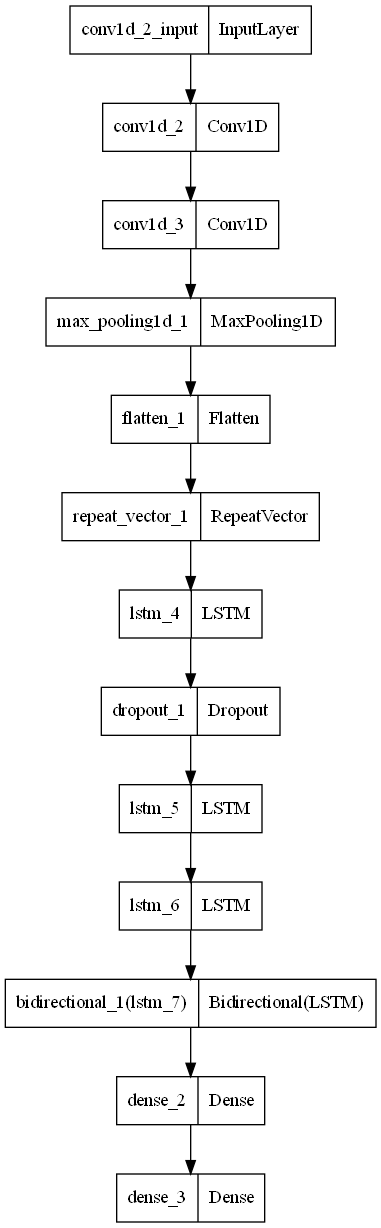

In [5]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [20]:
predicted_result=model.predict(X2020)

12/12 [==============================] - 2s 73ms/step


In [21]:
predicted_result=scalar.inverse_transform(predicted_result)
actual_ytest=scalar.inverse_transform(Y2020)

In [22]:
predicted_result

array([[ 6.85561323e+00,  2.76858151e-01],
       [ 5.18683243e+00,  1.63783208e-01],
       [ 8.69997215e+00,  6.54698789e-01],
       [ 1.04274521e+01,  6.06906056e-01],
       [ 5.62168074e+00,  5.61513543e-01],
       [ 8.05645084e+00,  5.44665158e-01],
       [ 8.26286030e+00,  3.00984204e-01],
       [ 7.93124914e+00,  3.59669626e-01],
       [ 1.07177353e+01,  2.36600757e-01],
       [ 9.03541279e+00,  8.56369257e-01],
       [ 5.65743589e+00,  5.64353764e-01],
       [ 7.52962160e+00,  4.25939769e-01],
       [ 9.54332352e+00,  5.24269760e-01],
       [ 8.00236988e+00,  1.10709190e+00],
       [ 8.77231884e+00,  2.07608461e+00],
       [ 8.22546005e+00,  1.75932431e+00],
       [ 8.42065525e+00,  1.38081121e+00],
       [ 9.09875488e+00,  9.29195285e-01],
       [ 5.01369381e+00,  7.74273574e-01],
       [ 5.07521915e+00,  1.11144447e+00],
       [ 5.69129229e+00,  2.70142168e-01],
       [ 3.84239507e+00,  1.47016108e-01],
       [ 5.00666428e+00,  5.31923056e-01],
       [ 8.

In [23]:
actual_ytest

array([[ 4.1,  0. ],
       [ 8.6,  1. ],
       [ 9.9,  0.6],
       [ 5.6,  0. ],
       [ 7.8,  0. ],
       [ 7.8,  0.8],
       [ 8.1,  0.2],
       [11.8,  1. ],
       [11.5,  4.2],
       [ 7.1,  0. ],
       [ 8. ,  0.6],
       [10.6,  0.2],
       [ 7.5,  5.6],
       [10.3, 10. ],
       [ 9.1,  3. ],
       [ 8.9,  4.4],
       [ 8.5,  1. ],
       [ 4.6,  0. ],
       [ 3.7,  0.2],
       [ 4.3,  0. ],
       [ 3. ,  0. ],
       [ 4.3,  0.2],
       [ 7.6,  0. ],
       [ 6.5,  0. ],
       [ 6.3,  0.2],
       [ 8.1,  2.4],
       [ 8.5,  9. ],
       [ 5.4,  0. ],
       [ 6. ,  0. ],
       [10. ,  0.2],
       [10.7,  1. ],
       [11.2,  8. ],
       [ 9.9,  0.6],
       [10.3,  0.2],
       [ 6.7,  0. ],
       [ 6. ,  0. ],
       [ 4.8,  0. ],
       [ 5. ,  1.2],
       [ 9.5,  0. ],
       [10.4, 13. ],
       [ 7.5,  3. ],
       [ 6. ,  0. ],
       [ 5.6, 10. ],
       [ 8. ,  1. ],
       [ 7.2,  3. ],
       [11.4,  8. ],
       [12.5, 12.2],
       [ 8.4,

In [24]:
from sklearn.metrics import mean_squared_error
print(f'The MSE of mean_temp prediction: {mean_squared_error(predicted_result[:,0],actual_ytest[:,0]):.3f}')
print(f'The MSE of precipitation prediction: {mean_squared_error(predicted_result[:,1],actual_ytest[:,1]):.3f}')

The MSE of mean_temp prediction: 5.589
The MSE of precipitation prediction: 9.829


In [31]:
# create a csv file
predicted_result1 = predicted_result[:, 1]
with open('../result_temp/mean_temp_predictions.txt', 'w') as file:
    # write the values to the file with two decimal places
    for prediction in predicted_result1:
        file.write(f"{prediction:.2f},")  # 使用字符串格式化来保留两位小数


Mean_temp

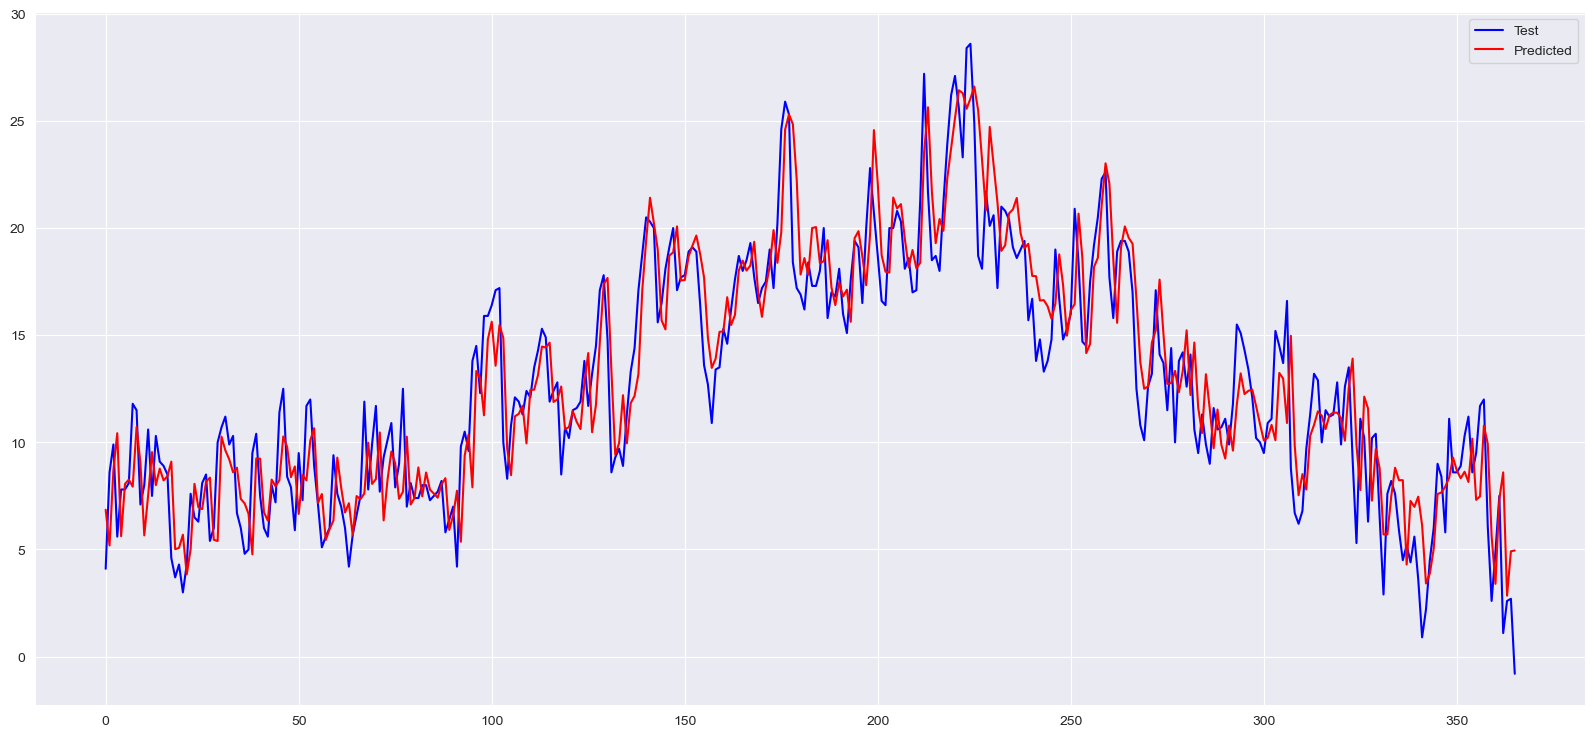

In [44]:
plt.figure(figsize=(20,9))
plt.plot(actual_ytest[:,0], 'blue')
plt.plot(predicted_result[:,0],'r')
plt.legend(('Test','Predicted'))
plt.show()

Precipitation

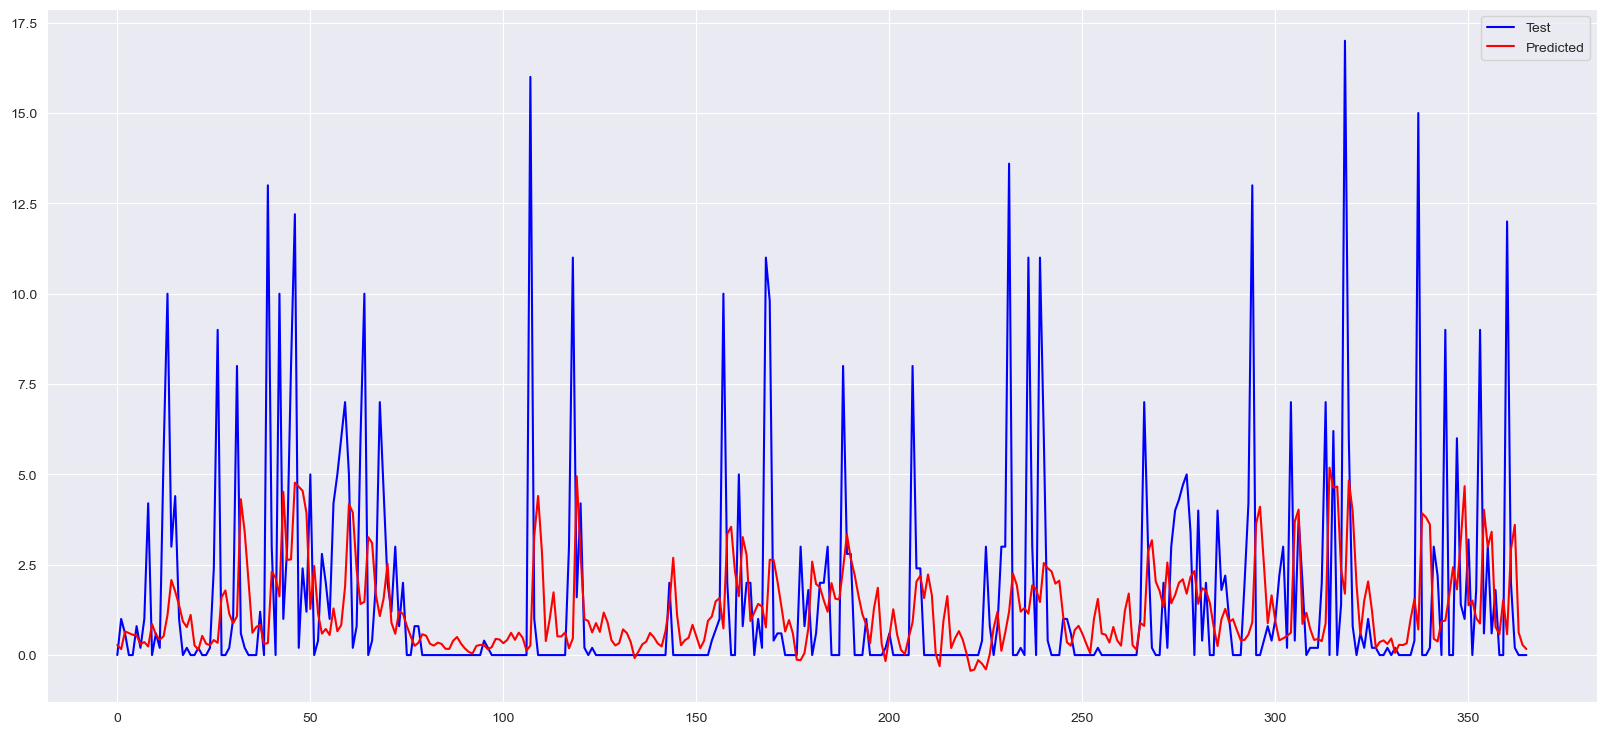

In [45]:
plt.figure(figsize=(20,9))
plt.plot(actual_ytest[:,1], 'blue')
plt.plot(predicted_result[:,1],'r')
plt.legend(('Test','Predicted'))
plt.show()

## Multiple output (predict one week ahead)